## Import Libraries

In [1]:
import os
import re
import pathlib
import json
import sqlalchemy as db

from datetime import datetime, date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf

import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected=True)


## Configurations

In [2]:
import quandl
import pandas_datareader as pdr
from pycoingecko import CoinGeckoAPI
import yfinance as yf

quandl.ApiConfig.api_key = "f6Y8avFQZwXp37ftC1_6"
cg = CoinGeckoAPI()


project_dir = pathlib.Path().absolute()
workdir = project_dir.parent
# print(f"{project_dir}\n{workdir}")

## Build functions

#### Local Functions for Data manipulation

In [3]:
def check_items(list1, list2):
    check = all(item in list1 for item in list2)
    return check

def value_mapper(df, col_name_to_map, new_col_name, mapping_dict):
    df[new_col_name] = df[col_name_to_map].str.upper().map(mapping_dict)
    return df

def df_subset(df, df_name, mapping_dict):
    columns_mapped = [i for i in mapping_dict[df_name][0]]
    df_subset = df[[column for column in df.columns if column in columns_mapped]]
    return df_subset


def column_rename(df, df_name, mapping_dict):
    df_renamed = df.rename(columns=mapping_dict[df_name][0])
    return df_renamed


def df_date_to_col(df):
    df_new_index = df.reset_index()
    df_date_col = df_new_index.rename(columns={'index': 'Date'})
    df_date_col.columns = df_date_col.columns.str.title()
    return df_date_col


def sql_preprocess(df, df_name, mapping_dict):
    df_sub = df_subset(df, df_name, mapping_dict)
    df_ren = column_rename(df_sub, df_name, mapping_dict)
    df_prep = df_date_to_col(df_ren)
    return df_prep


def create_date_table(start='1900-01-01', end='2099-12-31'):
   df = pd.DataFrame({"Date": pd.date_range(start, end)})
   df["Week_day"] = df.Date.dt.day_name()
   df["Day"] = df.Date.dt.day
   df["Month"] = df.Date.dt.month
   df["Week"] = df.Date.dt.isocalendar().week
   df["Quarter"] = df.Date.dt.quarter
   df["Year"] = df.Date.dt.year
   df.insert(0, 'DateID', (df.Year.astype(str) + df.Month.astype(str).str.zfill(2) + df.Day.astype(str).str.zfill(2)).astype(int))
   return df

def calculate_average(row_col):
    return row_col.mean()


#### Data Import functions

In [4]:
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

def get_json_data(data_id, json_path, provider):
    """Download and cache JSON data, return as a dataframe."""
    
    cache_path = f"{workdir}\\02_Resources\{data_id}.json"
    try:        
        f = open(cache_path, 'rb')
        df = pd.read_json(f)   
        print(f"Loaded {cache_path} from cache")
    except (OSError, IOError) as e:
        print(f"Downloading {data_id} from {provider}")
        df = pd.read_json(json_path)
        df.to_json(cache_path)
        print(f"Cached {data_id} at {cache_path}")
    return df



## Quandl Data import

def get_quandl_data(quandl_id):
    """" Download quandl data and load to json """
    
    data_id = quandl_id.replace('/', '-')
    provider = "Quandl"
    df = quandl.get(quandl_id, returns="pandas")
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


    
## Yahoo Finance Data import

def get_yfinance_data(ticker):
    """" Download yahoo finance data and load to json """
    
    data_id = re.sub(r'\W+', '_', ticker)
    provider = "Yahoo"
    df = yf.download(ticker)
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)

## Data Reader Data import

def get_datareader_data(datareader_id, provider):
    """" Download datareader data and load to json """
    data_id = datareader_id
    df = pdr.DataReader(datareader_id, provider)
    if df.shape[0]!=df.index.nunique():
        idx = np.unique(df.index.values, return_index=True)[1]
        df = df.iloc[idx]    
            
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


## Poloniex Data import

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2014-01-01', '%Y-%m-%d') # get data from the start of 2014
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_poloniex_data(poloniex_pair):
    """Retrieve cryptocurrency data from poloniex"""
    
    data_id = poloniex_pair
    provider="Poloniex"
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    df = get_json_data(data_id, json_url, poloniex_pair)
    df = df.set_index('date')
    return df


## Initial Data Exploration

### Look at Quandl Data

In [5]:
df_sample_quandl_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache


In [6]:
df_sample_quandl_kraken.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
2014-01-07,874.67040,892.06753,810.00000,810.00000,15.622378,13151.472844,841.835522
2014-01-08,810.00000,899.84281,788.00000,824.98287,19.182756,16097.329584,839.156269
2014-01-09,825.56345,870.00000,807.42084,841.86934,8.158335,6784.249982,831.572913
2014-01-10,839.99000,857.34056,817.00000,857.33056,8.024510,6780.220188,844.938794
2014-01-11,858.20000,918.05471,857.16554,899.84105,18.748285,16698.566929,890.671709


In [7]:
df_sample_quandl_kraken.index[0]

Timestamp('2014-01-07 00:00:00')

In [8]:
df_sample_quandl_kraken.index[-1]

Timestamp('2021-04-07 00:00:00')

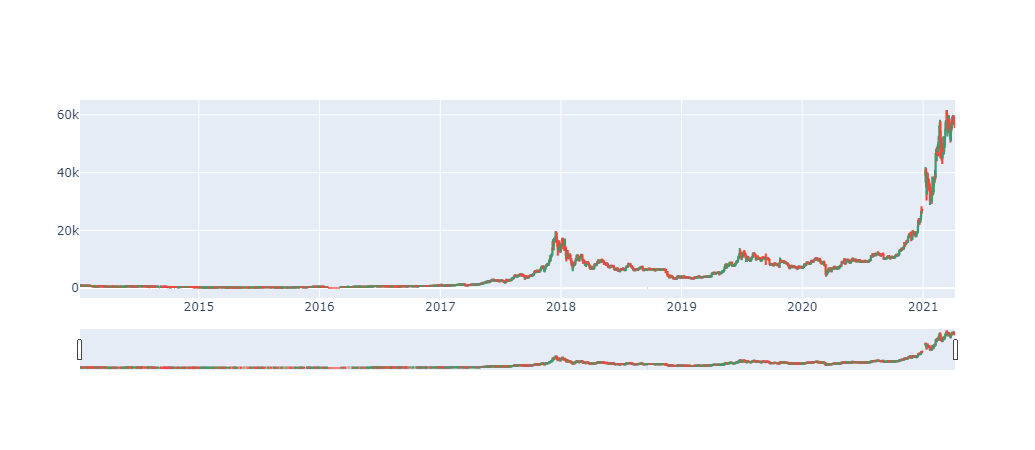

In [9]:
fig = go.Figure(data=[go.Candlestick(x=df_sample_quandl_kraken.index,
                open=df_sample_quandl_kraken['Open'],
                high=df_sample_quandl_kraken['High'],
                low=df_sample_quandl_kraken['Low'],
                close=df_sample_quandl_kraken['Close'])])
fig.show()

### Look at Coingecko market & exchange data

In [10]:
coins_list = cg.get_coins_list()
coin_names = []
for item in coins_list:
    coin_names.append(item['name'])

In [11]:
# jprint(coins_list)

In [12]:
markets_list = cg.get_coins_markets(vs_currency='usd')
market_names = []
for item in markets_list:
    market_names.append(item['name'])
len(market_names)

100

In [13]:
# jprint(markets_list)

In [14]:
df_cg_markets = pd.DataFrame.from_dict(markets_list)
df_cg_markets.head()

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,total_supply,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,58046.000000,1082508920220,1,1.217143e+12,55820700987,57987.000000,...,2.100000e+07,21000000.0,61712.00,-6.08097,2021-03-13T20:49:26.606Z,67.810000,8.537419e+04,2013-07-06T00:00:00.000Z,None,2021-04-08T14:42:53.093Z
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2048.720000,237106013383,2,NaN,31360415695,2054.900000,...,NaN,NaN,2153.08,-4.55997,2021-04-06T01:14:31.985Z,0.432979,4.744972e+05,2015-10-20T00:00:00.000Z,"{'times': 46.42727035908572, 'currency': 'btc'...",2021-04-08T14:43:51.546Z
2,binancecoin,bnb,Binance Coin,https://assets.coingecko.com/coins/images/825/...,417.990000,64590208804,3,7.127771e+10,6070398757,417.970000,...,1.705337e+08,170533651.9,417.97,0.00000,2021-04-08T14:39:56.824Z,0.039818,1.049606e+06,2017-10-19T00:00:00.000Z,None,2021-04-08T14:44:27.318Z
3,ripple,xrp,XRP,https://assets.coingecko.com/coins/images/44/l...,0.964507,44321494413,4,NaN,11777042648,0.986716,...,1.000000e+11,NaN,3.40,-71.59161,2018-01-07T00:00:00.000Z,0.002686,3.584083e+04,2014-05-22T00:00:00.000Z,None,2021-04-08T14:44:29.203Z
4,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.000000,43814950103,5,NaN,121481159198,1.000000,...,4.375180e+10,NaN,1.32,-24.31056,2018-07-24T00:00:00.000Z,0.572521,7.491819e+01,2015-03-02T00:00:00.000Z,None,2021-04-08T14:06:09.154Z


In [15]:
exchanges_list = cg.get_exchanges_list()
exchange_names = []
for item in exchanges_list:
    exchange_names.append(item['name'])
len(exchange_names)

100

In [16]:
# jprint(exchanges_list)

In [17]:
df_cg_exchanges = pd.DataFrame.from_dict(exchanges_list)
df_cg_exchanges.head()

,id,name,year_established,country,description,url,image,has_trading_incentive,trust_score,trust_score_rank,trade_volume_24h_btc,trade_volume_24h_btc_normalized
0,binance,Binance,2017.0,Cayman Islands,,https://www.binance.com/,https://assets.coingecko.com/markets/images/52...,False,10,1,586063.076936,586063.076936
1,gdax,Coinbase Pro,2012.0,United States,,https://www.coinbase.com,https://assets.coingecko.com/markets/images/23...,False,10,2,44759.037886,44759.037886
2,kraken,Kraken,2011.0,United States,,https://r.kraken.com/Q1m9x,https://assets.coingecko.com/markets/images/29...,False,10,3,25106.231872,25106.231872
3,bitfinex,Bitfinex,2014.0,British Virgin Islands,,https://www.bitfinex.com,https://assets.coingecko.com/markets/images/4/...,False,10,4,18718.281855,18718.281855
4,binance_us,Binance US,2019.0,United States,,https://www.binance.us/en,https://assets.coingecko.com/markets/images/46...,False,10,5,10715.106871,10715.106871


### Look at Coingecko BTC data

In [18]:
start_date = datetime.strptime("2014-01-07", "%Y-%m-%d")
end_date = datetime.strptime("2021-04-01", "%Y-%m-%d")
timestamp_start = datetime.timestamp(start_date)
timestamp_end = datetime.timestamp(end_date)

In [19]:
btc_charts_data = cg.get_coin_market_chart_range_by_id("bitcoin", "usd", timestamp_start, timestamp_end)

In [20]:
# jprint(btc_charts_data)

In [21]:
for key, value in enumerate(btc_charts_data):
    elements = []
    for element in btc_charts_data[value]:
        elements.append(element)
    print(f"{value}: # {len(elements)}")

prices: # 2640
market_caps: # 2639
total_volumes: # 2640


In [22]:
df_btc_charts_data_mc = pd.DataFrame.from_dict(btc_charts_data['market_caps'])
df_btc_charts_data_mc.rename(columns={0:'timestamp', 1:'market_cap'}, inplace=True)
df_btc_charts_data_mc['datetime'] = pd.to_datetime(df_btc_charts_data_mc['timestamp'], unit='ms')
df_btc_charts_data_mc.drop('timestamp', axis=1, inplace=True)
df_btc_charts_data_mc.set_index('datetime', inplace=True)
print(f"Duplicated indices: {df_btc_charts_data_mc.index.duplicated().sum()}")
df_btc_charts_data_mc.tail()

Duplicated indices: 0


,market_cap
datetime,
2021-03-27,1.027210e+12
2021-03-28,1.042184e+12
2021-03-29,1.039334e+12
2021-03-30,1.075942e+12
2021-03-31,1.095293e+12


In [23]:
df_btc_charts_data_mc = pd.DataFrame.from_dict(btc_charts_data['market_caps'])
df_btc_charts_data_mc.rename(columns={0:'timestamp', 1:'market_cap'}, inplace=True)

df_btc_charts_data_pc = pd.DataFrame.from_dict(btc_charts_data['prices'])
df_btc_charts_data_pc.rename(columns={0:'timestamp', 1:'price'}, inplace=True)

df_btc_charts_data_vol = pd.DataFrame.from_dict(btc_charts_data['total_volumes'])
df_btc_charts_data_vol.rename(columns={0:'timestamp', 1:'volume'}, inplace=True)


In [24]:
df_btc_charts_merged = df_btc_charts_data_mc.merge(df_btc_charts_data_pc, how="inner", 
                                                   left_on='timestamp', right_on='timestamp').merge(df_btc_charts_data_vol,
                                                                                                                how='inner', left_on='timestamp', 
                                                                                                                 right_on='timestamp')
df_btc_charts_merged.tail()

,timestamp,market_cap,price,volume
2634,1616803200000,1.027210e+12,55033.100480,5.544256e+10
2635,1616889600000,1.042184e+12,55832.418110,4.728575e+10
2636,1616976000000,1.039334e+12,55728.101328,4.931585e+10
2637,1617062400000,1.075942e+12,57634.928694,5.738704e+10
2638,1617148800000,1.095293e+12,58668.628337,5.238754e+10


In [25]:
df_btc_charts_merged['datetime'] = pd.to_datetime(df_btc_charts_merged['timestamp'], unit='ms')
df_cg_btc_data = df_btc_charts_merged.set_index('datetime')
df_cg_btc_data.drop('timestamp', axis=1, inplace=True)
df_cg_btc_data.tail()

,market_cap,price,volume
datetime,,,
2021-03-27,1.027210e+12,55033.100480,5.544256e+10
2021-03-28,1.042184e+12,55832.418110,4.728575e+10
2021-03-29,1.039334e+12,55728.101328,4.931585e+10
2021-03-30,1.075942e+12,57634.928694,5.738704e+10
2021-03-31,1.095293e+12,58668.628337,5.238754e+10


In [26]:
print(f"Duplicated indices: {df_cg_btc_data.index.duplicated().sum()}")
print(df_cg_btc_data.nunique())

Duplicated indices: 0
market_cap    2639
price         2638
volume        2639
dtype: int64


In [27]:
df_cg_btc_data[df_cg_btc_data.index.duplicated()]

,market_cap,price,volume
datetime,,,


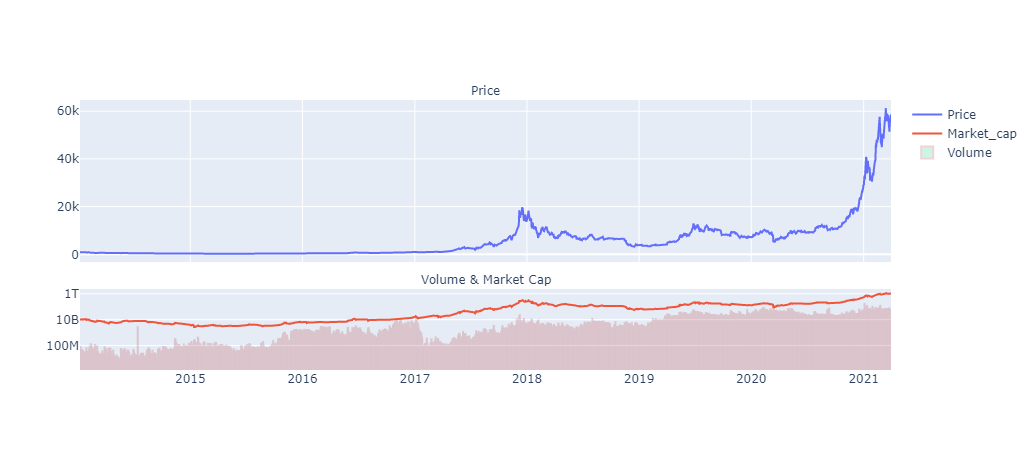

In [28]:
fig = go.Figure()

date = df_cg_btc_data.index
price = df_cg_btc_data['price']
market_cap = df_cg_btc_data['market_cap']
volume = df_cg_btc_data['volume']

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('Price', 'Volume & Market Cap'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=date, y=price,
                    mode='lines',
                    name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=date, y=market_cap,
                    name='Market_cap'), row=2, col=1)

fig.add_trace(go.Bar(x=date, y=volume,
                     name='Volume',
                     opacity=0.2,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)



fig.update_layout(yaxis2_type="log")

fig.show()

### Look at Yahoo Finance BTC data

In [29]:
df_yahoo_btc_data = get_datareader_data('BTC-USD', "yahoo")
df_yahoo_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC-USD.json from cache


,High,Low,Open,Close,Volume,Adj Close
2021-04-02,60110.269531,57603.890625,59397.410156,57603.890625,59641344484,57603.890625
2021-04-03,58913.746094,57168.675781,57604.839844,58758.554688,50749662970,58758.554688
2021-04-04,59891.296875,57694.824219,58760.875000,59057.878906,60706272115,59057.878906
2021-04-05,59479.578125,57646.808594,59171.933594,58192.359375,66058027988,58192.359375
2021-04-07,58731.144531,55664.093750,56048.933594,56605.425781,75652292608,56605.425781


### Comparison Chart BTC Closing Price

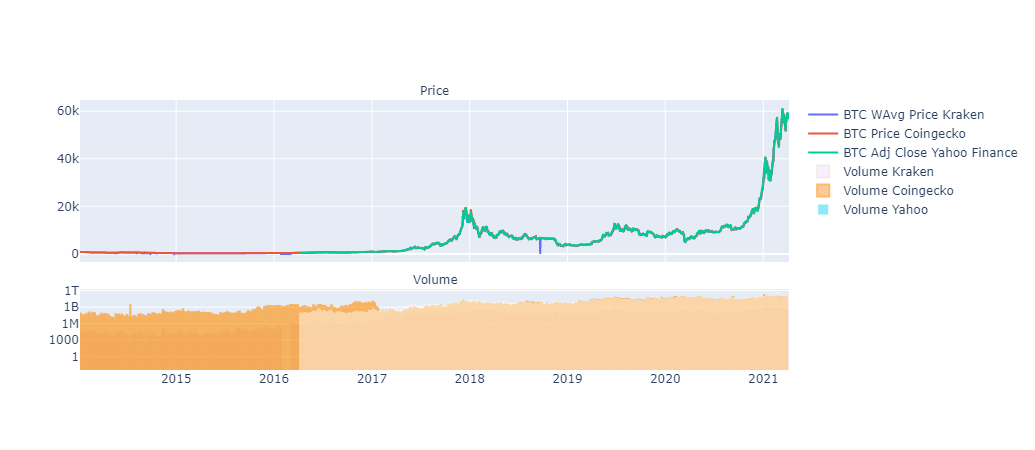

In [30]:
fig = go.Figure()

quandl_kraken = df_sample_quandl_kraken
coingecko = df_cg_btc_data
yahoo = df_yahoo_btc_data

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('Price', 'Volume'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=quandl_kraken.index, y=quandl_kraken['Weighted Price'],
                         mode='lines',
                         name='BTC WAvg Price Kraken'), row=1, col=1)

fig.add_trace(go.Scatter(x=coingecko.index, y=coingecko['price'],
                         mode='lines',
                         name='BTC Price Coingecko'), row=1, col=1)

fig.add_trace(go.Scatter(x=yahoo.index, y=yahoo['Adj Close'],
                         mode='lines',
                         name='BTC Adj Close Yahoo Finance'), row=1, col=1)


fig.add_trace(go.Bar(x=quandl_kraken.index, y=quandl_kraken['Volume (Currency)'],
                     name='Volume Kraken',
                     opacity=0.1,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.add_trace(go.Bar(x=coingecko.index, y=coingecko['volume'],
                     name='Volume Coingecko',
                     opacity=0.6,
                     marker=dict(
                         line=dict(color='darkorange', width=2)
                     )), row=2, col=1)

fig.add_trace(go.Bar(x=yahoo.index, y=yahoo['Volume'],
                     name='Volume Yahoo',
                     opacity=0.5,
                     marker=dict(
                         line=dict(color='floralwhite', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)

fig.update_layout(yaxis2_type="log")

fig.show()

## Data Ingestion: Populate BTC Data

### Inject more Exchange data from Quandl

In [31]:
from quandl.errors.quandl_error import NotFoundError

exchanges = df_cg_exchanges['id'].str.upper()

df_run_all = []
    
for exchange in exchanges:
    exchange_code = f"BCHARTS/{exchange}USD"
   
    try:
        df = get_quandl_data(exchange_code)
        df['Exchange'] = exchange
        df_run_all.append(df)
        
    except NotFoundError as e:
        continue

df_quandl_btc_data = pd.concat(df_run_all)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFINEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITSTAMPUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-CEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFLYERUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-OKCOINUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-ITBITUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-HITBTCUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-P2PB2BUSD.json from cache


In [32]:
df_quandl_btc_data.rename(columns={'Volume (BTC)': 'Volume_BTC', 'Volume (Currency)': 'Volume_USD'}, inplace=True)
df_quandl_btc_data.tail()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange
2019-07-03,10565.56,11958.99,10556.26,11944.45,530.714067,5.990767e+06,11288.125819,P2PB2B
2019-07-04,11940.06,12091.74,11130.05,11178.62,439.132629,5.137788e+06,11699.854040,P2PB2B
2019-07-05,11122.02,11471.84,10830.00,11058.25,511.780219,5.710787e+06,11158.671088,P2PB2B
2019-07-06,11058.25,11755.88,11056.83,11341.20,487.073920,5.542443e+06,11379.058714,P2PB2B
2019-07-07,11341.20,11466.66,9509.84,11258.45,352.096505,3.985677e+06,11319.843348,P2PB2B


In [33]:
df_quandl_btc_data.sort_index()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange
2011-09-13,5.80,6.00,5.65,5.97,58.371382,3.460974e+02,5.929231,BITSTAMP
2011-09-14,5.58,5.72,5.52,5.53,61.145984,3.418548e+02,5.590798,BITSTAMP
2011-09-15,5.12,5.24,5.00,5.13,80.140795,4.082590e+02,5.094272,BITSTAMP
2011-09-16,4.82,4.87,4.80,4.85,39.914007,1.937631e+02,4.854515,BITSTAMP
2011-09-17,4.87,4.87,4.87,4.87,0.300000,1.461000e+00,4.870000,BITSTAMP
...,...,...,...,...,...,...,...,...
2021-04-06,59120.00,59462.80,57377.10,58017.10,2656.521275,1.550577e+08,58368.715387,KRAKEN
2021-04-06,59135.36,59473.90,57216.00,58018.30,2711.397847,1.580943e+08,58307.308273,BITSTAMP
2021-04-07,57966.30,58531.30,55426.90,56433.00,216.640963,1.228639e+07,56713.133532,CEX
2021-04-07,58017.20,58652.10,55460.00,56407.10,4890.372655,2.776886e+08,56782.705907,KRAKEN


### Inject BTC Data from Poloniex

In [34]:
df_poloniex_btc_data = get_poloniex_data("USDT_BTC")
df_poloniex_btc_data.columns= df_poloniex_btc_data.columns.str.title()
df_poloniex_btc_data = df_poloniex_btc_data.rename(columns={'Volume': 'Volume_USD', 'Quotevolume': 'Volume_BTC',  
                                                     'Weightedaverage': 'Weighted Price'})

df_poloniex_btc_data['Exchange'] = 'POLONIEX'
column_names_btc=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD', 'Weighted Price', 'Exchange']
df_poloniex_btc_data = df_poloniex_btc_data.reindex(columns=column_names_btc)

df_poloniex_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\USDT_BTC.json from cache


,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange
date,,,,,,,,
2021-03-27,55008.350978,56645.325460,53967.742633,55855.274815,521.355309,2.880248e+07,55245.398905,POLONIEX
2021-03-28,55828.000000,56517.750699,54700.000000,55773.962120,426.410099,2.379101e+07,55793.739993,POLONIEX
2021-03-29,55769.134151,58332.142365,54940.245881,57620.809447,786.820766,4.498012e+07,57166.920136,POLONIEX
2021-03-30,57614.000000,59360.000000,57085.000000,58748.000000,508.525830,2.964910e+07,58304.022460,POLONIEX
2021-03-31,58748.000000,59782.490733,56846.531521,58743.337525,1025.147455,6.003219e+07,58559.565409,POLONIEX


In [35]:
df_poloniex_btc_data.sort_index()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange
date,,,,,,,,
2015-02-19,225.000000,244.000000,225.000000,244.000000,0.193117,4.627631e+01,239.627778,POLONIEX
2015-02-20,240.250118,245.000000,240.250000,240.250000,0.230429,5.589490e+01,242.568479,POLONIEX
2015-02-21,245.000000,245.000000,245.000000,245.000000,0.060091,1.472224e+01,245.000000,POLONIEX
2015-02-22,245.000000,249.000000,235.000000,235.000000,0.539055,1.291212e+02,239.532608,POLONIEX
2015-02-23,235.000002,235.001000,235.000000,235.000000,0.410926,9.656756e+01,235.000062,POLONIEX
...,...,...,...,...,...,...,...,...
2021-03-27,55008.350978,56645.325460,53967.742633,55855.274815,521.355309,2.880248e+07,55245.398905,POLONIEX
2021-03-28,55828.000000,56517.750699,54700.000000,55773.962120,426.410099,2.379101e+07,55793.739993,POLONIEX
2021-03-29,55769.134151,58332.142365,54940.245881,57620.809447,786.820766,4.498012e+07,57166.920136,POLONIEX


### Append Poloniex Data to have the final BTC Dataset

In [36]:
df_btc_data = df_quandl_btc_data.append(df_poloniex_btc_data)
df_btc_data.sort_values(by=['Exchange'])
df_btc_data.tail()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange
2021-03-27,55008.350978,56645.325460,53967.742633,55855.274815,521.355309,2.880248e+07,55245.398905,POLONIEX
2021-03-28,55828.000000,56517.750699,54700.000000,55773.962120,426.410099,2.379101e+07,55793.739993,POLONIEX
2021-03-29,55769.134151,58332.142365,54940.245881,57620.809447,786.820766,4.498012e+07,57166.920136,POLONIEX
2021-03-30,57614.000000,59360.000000,57085.000000,58748.000000,508.525830,2.964910e+07,58304.022460,POLONIEX
2021-03-31,58748.000000,59782.490733,56846.531521,58743.337525,1025.147455,6.003219e+07,58559.565409,POLONIEX


In [37]:
df_btc_data['Market'] = "BTC"
df_btc_data.sort_index()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange,Market
2011-09-13,5.80,6.00,5.65,5.97,58.371382,3.460974e+02,5.929231,BITSTAMP,BTC
2011-09-14,5.58,5.72,5.52,5.53,61.145984,3.418548e+02,5.590798,BITSTAMP,BTC
2011-09-15,5.12,5.24,5.00,5.13,80.140795,4.082590e+02,5.094272,BITSTAMP,BTC
2011-09-16,4.82,4.87,4.80,4.85,39.914007,1.937631e+02,4.854515,BITSTAMP,BTC
2011-09-17,4.87,4.87,4.87,4.87,0.300000,1.461000e+00,4.870000,BITSTAMP,BTC
...,...,...,...,...,...,...,...,...,...
2021-04-06,59135.36,59473.90,57216.00,58018.30,2711.397847,1.580943e+08,58307.308273,BITSTAMP,BTC
2021-04-06,59120.00,59462.80,57377.10,58017.10,2656.521275,1.550577e+08,58368.715387,KRAKEN,BTC
2021-04-07,57966.30,58531.30,55426.90,56433.00,216.640963,1.228639e+07,56713.133532,CEX,BTC
2021-04-07,58024.90,58668.00,55441.93,56420.44,5330.356138,3.021940e+08,56693.026676,BITSTAMP,BTC


## Data Ingestion: Populate Altcoin Data

In [38]:
df_cg_markets['symbol']

0      btc
1      eth
2      bnb
3      xrp
4     usdt
      ... 
95    ankr
96     rsr
97    iost
98     wrx
99     amp
Name: symbol, Length: 100, dtype: object

In [39]:
from quandl.errors.quandl_error import NotFoundError

markets = df_cg_markets['symbol'].str.upper()

df_run_mkt_new = []
    
for market in markets:
    market_code = f"BITFINEX/{market}BTC"
   
    try:
        df = get_quandl_data(market_code)
        df['Market'] = market
        df_run_mkt_new.append(df)
        
    except NotFoundError as e:
        continue

df_altcoin_quandl = pd.concat(df_run_mkt_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ETHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XRPBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-DOTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ADABTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-LTCBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BCHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XLMBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-TRXBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-VETBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BTTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-EOSBTC.json

In [40]:
df_altcoin_quandl_data = df_altcoin_quandl.sort_index()

In [41]:
df_altcoin_quandl_data

,High,Low,Mid,Last,Bid,Ask,Volume,Market
2014-04-15,0.025870,0.024502,0.025606,0.025669,0.025366,0.025845,1.430187e+03,LTC
2014-04-16,0.026310,0.025050,0.025303,0.025111,0.025110,0.025497,1.774144e+03,LTC
2014-04-17,0.026025,0.025111,0.025445,0.025550,0.025341,0.025550,9.852923e+02,LTC
2014-04-18,0.026439,0.025001,0.025251,0.025486,0.025094,0.025408,1.372240e+03,LTC
2014-04-19,0.025789,0.025000,0.025616,0.025460,0.025451,0.025782,2.330634e+03,LTC
...,...,...,...,...,...,...,...,...
2021-04-07,0.000022,0.000021,0.000021,0.000021,0.000021,0.000021,5.750732e+05,ADA
2021-04-07,0.000753,0.000674,0.000713,0.000717,0.000712,0.000713,2.193003e+04,DOT
2021-04-07,0.000019,0.000015,0.000017,0.000017,0.000017,0.000017,3.312960e+07,XRP
2021-04-07,0.001753,0.001176,0.001407,0.001413,0.001400,0.001413,2.348164e+04,BTG


In [42]:
altcoins = markets
df_run_altcoin_new = []

for altcoin in altcoins:
    coinpair = f"BTC_{altcoin}"
    try:
        df = get_poloniex_data(coinpair)
        df['Market'] = altcoin
        df_run_altcoin_new.append(df)
                
    except ValueError as e:
        continue

df_altcoin_poloniex = pd.concat(df_run_altcoin_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ETH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XRP.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOT.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LINK.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_BCH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_TRX.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_WBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOGE.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_EOS.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ATOM.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XMR.json

In [43]:
df_altcoin_poloniex_data = df_altcoin_poloniex.sort_index()

In [44]:
df_altcoin_poloniex_data

,high,low,open,close,volume,quoteVolume,weightedAverage,Market
date,,,,,,,,
2014-01-18,2.900000e-02,2.800000e-02,2.800000e-02,2.850000e-02,0.023696,8.450990e-01,2.803904e-02,LTC
2014-01-19,2.830000e-02,2.830000e-02,2.830000e-02,2.830000e-02,0.000311,1.100000e-02,2.830000e-02,LTC
2014-01-20,2.830000e-02,2.830000e-02,2.830000e-02,2.830000e-02,0.000000,0.000000e+00,2.830000e-02,LTC
2014-01-21,2.830000e-02,2.830000e-02,2.830000e-02,2.830000e-02,0.000000,0.000000e+00,2.830000e-02,LTC
2014-01-21,2.300000e-06,2.200000e-06,2.200000e-06,2.300000e-06,0.013465,6.000000e+03,2.240000e-06,DOGE
...,...,...,...,...,...,...,...,...
2021-03-31,9.820000e-06,9.030000e-06,9.570000e-06,9.690000e-06,60.303899,6.414147e+06,9.400000e-06,XRP
2021-03-31,1.854000e-05,1.700000e-05,1.849000e-05,1.735000e-05,0.422235,2.393405e+04,1.764000e-05,MANA
2021-03-31,3.303254e-02,3.093452e-02,3.134943e-02,3.262643e-02,269.064868,8.511722e+03,3.161109e-02,ETH


In [45]:
df_altcoin_quandl_data[(df_altcoin_quandl_data.index=='2021-03-31') & (df_altcoin_quandl_data['Market']=='ETH')]

,High,Low,Mid,Last,Bid,Ask,Volume,Market
2021-03-31,0.033025,0.030936,0.032581,0.032573,0.032573,0.032589,13509.825329,ETH


In [46]:
df_altcoin_poloniex_data[(df_altcoin_poloniex_data.index=='2021-03-31') & (df_altcoin_poloniex_data['Market']=='ETH')]

,high,low,open,close,volume,quoteVolume,weightedAverage,Market
date,,,,,,,,
2021-03-31,0.033033,0.030935,0.031349,0.032626,269.064868,8511.722203,0.031611,ETH


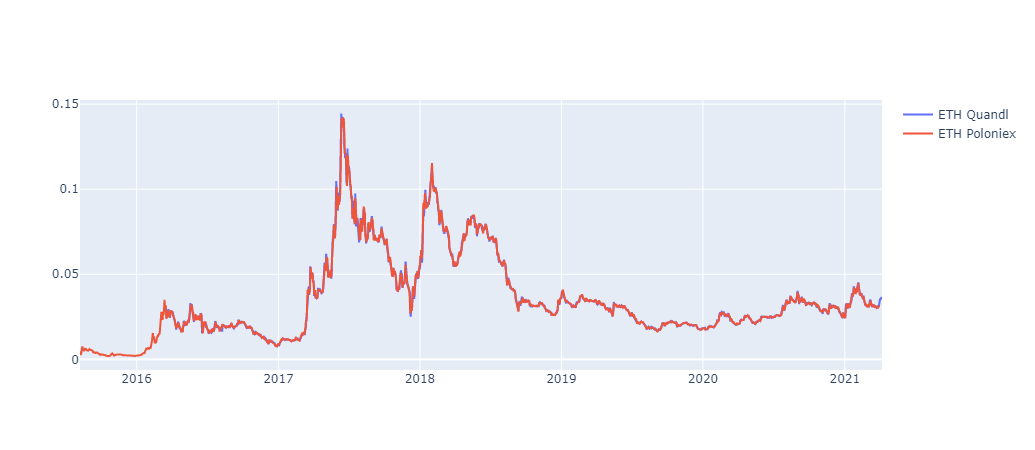

In [47]:
fig = go.Figure()

eth_quandl = df_altcoin_quandl_data[df_altcoin_quandl_data['Market']=='ETH']
eth_poloniex = df_altcoin_poloniex_data[df_altcoin_poloniex_data['Market']=='ETH']

fig.add_trace(go.Scatter(x=eth_quandl.index, y=eth_quandl['Last'],
                         mode='lines',
                         name='ETH Quandl'))

fig.add_trace(go.Scatter(x=eth_poloniex.index, y=eth_poloniex['weightedAverage'],
                         mode='lines',
                         name='ETH Poloniex'))

fig.show()

In [48]:
print(eth_quandl.shape)
print(eth_poloniex.shape)

(1808, 8)
(2063, 8)


In [49]:
print(len(set(df_altcoin_quandl_data['Market'])))
print(len(set(df_altcoin_poloniex_data['Market'])))

30
32


In [50]:
print(df_altcoin_quandl_data.isna().sum())
print(df_altcoin_poloniex_data.isna().sum())

High      0
Low       0
Mid       0
Last      0
Bid       0
Ask       0
Volume    0
Market    0
dtype: int64
high               0
low                0
open               0
close              0
volume             0
quoteVolume        0
weightedAverage    0
Market             0
dtype: int64


#### Take Poloniex for Altcoin data

In [51]:
df_altcoin_poloniex_data.columns = df_altcoin_poloniex_data.columns.str.title()
df_altcoin_poloniex_data = df_altcoin_poloniex_data.rename(columns={'Volume': 'Volume_BTC', 'Quotevolume': 'Volume_Market',  
                                                     'Weightedaverage': 'Weighted Price'})

df_altcoin_poloniex_data['Exchange'] = 'POLONIEX'
column_names_altcoin=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Market', 'Weighted Price', 'Exchange', 'Market']
df_altcoin_poloniex_data = df_altcoin_poloniex_data.reindex(columns=column_names_altcoin)

df_altcoin_poloniex_data.tail()

,Open,High,Low,Close,Volume_BTC,Volume_Market,Weighted Price,Exchange,Market
date,,,,,,,,,
2021-03-31,9.570000e-06,9.820000e-06,9.030000e-06,9.690000e-06,60.303899,6.414147e+06,9.400000e-06,POLONIEX,XRP
2021-03-31,1.849000e-05,1.854000e-05,1.700000e-05,1.735000e-05,0.422235,2.393405e+04,1.764000e-05,POLONIEX,MANA
2021-03-31,3.134943e-02,3.303254e-02,3.093452e-02,3.262643e-02,269.064868,8.511722e+03,3.161109e-02,POLONIEX,ETH
2021-03-31,4.300000e-07,4.500000e-07,4.000000e-07,4.400000e-07,7.483935,1.753603e+07,4.200000e-07,POLONIEX,SC
2021-03-31,4.700000e-07,4.900000e-07,4.500000e-07,4.700000e-07,0.063275,1.355640e+05,4.600000e-07,POLONIEX,AMP


### Inject Other relevant Data

In [52]:
# Get Bitcoin mining data

df_mining_data = get_quandl_data('BITCOINWATCH/MINING')
df_mining_data['Market'] = 'BTC'
df_mining_data['Source'] = 'BITCOINWATCH'
df_mining_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITCOINWATCH-MINING.json from cache


,Total BTC,Market Cap,Transactions last 24h,Transactions avg. per hour,Bitcoins sent last 24h,Bitcoins sent avg. per hour,Count,Blocks last 24h,Blocks avg. per hour,Difficulty,Next Difficulty,Network Hashrate Terahashs,Network Hashrate PetaFLOPS,Market,Source
2021-04-02,16522800,950437719840,NaN,NaN,NaN,NaN,481823,0,0.0,923233068449,887736944047,6354668.57,80704290.84,BTC,BITCOINWATCH
2021-04-03,16522800,960799167720,NaN,NaN,NaN,NaN,481823,0,0.0,923233068449,887736944047,6354668.57,80704290.84,BTC,BITCOINWATCH
2021-04-04,16522800,972988037280,NaN,NaN,NaN,NaN,481823,0,0.0,923233068449,887736944047,6354668.57,80704290.84,BTC,BITCOINWATCH
2021-04-05,16522800,956926223400,NaN,NaN,NaN,NaN,481823,0,0.0,923233068449,887736944047,6354668.57,80704290.84,BTC,BITCOINWATCH
2021-04-06,16522800,932710407720,NaN,NaN,NaN,NaN,481823,0,0.0,923233068449,887736944047,6354668.57,80704290.84,BTC,BITCOINWATCH


In [53]:
tickers = {
    'Oil_Price': 'CL=F',
    'Gold_Price': 'GC=F',
    'SP500': '^GSPC',
    'DJI': '^DJI',
    'Nasdaq': '^IXIC',
    'Tesla': 'TSLA'
}

asset_list = []

for name, ticker in tickers.items():
    df = get_yfinance_data(ticker)
    df['Asset'] = name
    df['Symbol'] = re.sub(r'\W+', '', ticker)
    df['Source'] = 'YAHOO'
    asset_list.append(df)
    
df_asset_data = pd.concat(asset_list)


[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\CL_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\GC_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_GSPC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_DJI.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_IXIC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\TSLA.json from cache


In [54]:
df_asset_data

,Open,High,Low,Close,Adj Close,Volume,Asset,Symbol,Source
2000-08-23,31.950001,32.799999,31.950001,32.049999,32.049999,79385,Oil_Price,CLF,YAHOO
2000-08-24,31.900000,32.240002,31.400000,31.629999,31.629999,72978,Oil_Price,CLF,YAHOO
2000-08-25,31.700001,32.099998,31.320000,32.049999,32.049999,44601,Oil_Price,CLF,YAHOO
2000-08-28,32.040001,32.919998,31.860001,32.869999,32.869999,46770,Oil_Price,CLF,YAHOO
2000-08-29,32.820000,33.029999,32.560001,32.720001,32.720001,49131,Oil_Price,CLF,YAHOO
...,...,...,...,...,...,...,...,...,...
2021-03-31,646.619995,672.000000,641.109985,667.929993,667.929993,33337300,Tesla,TSLA,YAHOO
2021-04-01,688.369995,692.419983,659.419983,661.750000,661.750000,35298400,Tesla,TSLA,YAHOO
2021-04-05,707.710022,708.159973,684.700012,691.049988,691.049988,41842800,Tesla,TSLA,YAHOO
2021-04-06,690.299988,696.549988,681.369995,691.619995,691.619995,28234200,Tesla,TSLA,YAHOO


## Organize Data

### Create Date Table

In [55]:
df_dates = create_date_table()
df_dates

,DateID,Date,Week_day,Day,Month,Week,Quarter,Year
0,19000101,1900-01-01,Monday,1,1,1,1,1900
1,19000102,1900-01-02,Tuesday,2,1,1,1,1900
2,19000103,1900-01-03,Wednesday,3,1,1,1,1900
3,19000104,1900-01-04,Thursday,4,1,1,1,1900
4,19000105,1900-01-05,Friday,5,1,1,1,1900
...,...,...,...,...,...,...,...,...
73044,20991227,2099-12-27,Sunday,27,12,52,4,2099
73045,20991228,2099-12-28,Monday,28,12,53,4,2099
73046,20991229,2099-12-29,Tuesday,29,12,53,4,2099
73047,20991230,2099-12-30,Wednesday,30,12,53,4,2099


### Tranform DataFrames

<p><strong>Relevant Dataframes:</strong></p>
<ul style="line-height:180%">
    <li>BTC Data: df_btc_data</li>
    <li>Altcoin Data: df_altcoin_poloniex_data</li>
    <li>Fin Assets Data: df_asset_data</li>
    <li>Mining Data: df_mining_data</li>
    <li>Exchanges Data: df_cg_exchanges</li>
    <li>Markets Data: df_cg_markets</li>
    <li>Coingecko BTC Price Data: df_cg_btc_data</li>
    <li>Yahoo BTC Price Data: df_yahoo_btc_data</li>
    <li>Date Table: df_dates</li>
</ul>

In [56]:
# Create copies of the imported data that is being transformed

df_btc = df_btc_data
df_altcoin = df_altcoin_poloniex_data
df_fin_asset = df_asset_data
df_mining = df_mining_data
df_exchanges = df_cg_exchanges
df_markets = df_cg_markets


data_frames = {
    'BTC Data': df_btc,
    'Altcoin Data': df_altcoin,
    'Fin Assets Data': df_fin_asset,
    'Mining Data': df_mining,
    'Exchanges Data': df_exchanges,
    'Markets Data': df_markets,
    'Coingecko BTC Price Data': df_cg_btc_data,
    'Yahoo BTC Price Data': df_yahoo_btc_data,
    'Date Table': df_dates
}

In [57]:
data_frames_col_names = {}
for df_name, df in data_frames.items():
    data_frames_col_names[df_name] = df.columns
    

In [58]:
data_frames_col_names

{'BTC Data': Index(['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD',
        'Weighted Price', 'Exchange', 'Market'],
       dtype='object'),
 'Altcoin Data': Index(['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Market',
        'Weighted Price', 'Exchange', 'Market'],
       dtype='object'),
 'Fin Assets Data': Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Asset',
        'Symbol', 'Source'],
       dtype='object'),
 'Mining Data': Index(['Total BTC', 'Market Cap', 'Transactions last 24h',
        'Transactions avg. per hour', 'Bitcoins sent last 24h',
        'Bitcoins sent avg. per hour', 'Count', 'Blocks last 24h',
        'Blocks avg. per hour', 'Difficulty', 'Next Difficulty',
        'Network Hashrate Terahashs', 'Network Hashrate PetaFLOPS', 'Market',
        'Source'],
       dtype='object'),
 'Exchanges Data': Index(['id', 'name', 'year_established', 'country', 'description', 'url',
        'image', 'has_trading_incentive', 'trust_score', '

In [59]:
# Check the existence of used exchanges in the full exchange list

exchanges_list_cg = pd.unique(df_exchanges['id'].str.upper())
exchanges_list_cg= np.append(exchanges_list_cg, ['YAHOO'])
exchanges_list_cg.sort()
exchanges_list_cg

exchanges_used = pd.unique(df_btc['Exchange'])
exchanges_used.sort()
print(f"{exchanges_list_cg}\n" \
      f"{exchanges_used}")
check_items(exchanges_list_cg, exchanges_used)

['AEX' 'ALTERDICE' 'BANCOR' 'BIBOX' 'BIDESK' 'BIGONE' 'BIKI' 'BINANCE'
 'BINANCE_US' 'BITBANK' 'BITCOIN_COM' 'BITFINEX' 'BITFLYER' 'BITFOREX'
 'BITGET' 'BITHUMB' 'BITHUMB_GLOBAL' 'BITKUB' 'BITMART' 'BITMAX'
 'BITOFFER' 'BITOPRO' 'BITPANDA' 'BITRUE' 'BITSO' 'BITSTAMP' 'BITTREX'
 'BIT_Z' 'BKEX' 'BLOCKCHAIN_COM' 'BTCBOX' 'BTCMARKETS' 'BTCTURK'
 'BTC_ALPHA' 'BTSE' 'BW' 'CEX' 'CHANGELLY' 'COINBENE' 'COINCHECK'
 'COINDEAL' 'COINEAL' 'COINMARGIN' 'COINONE' 'COINSBIT' 'COINTIGER'
 'CRYPTOLOGY' 'CRYPTO_COM' 'CURRENCY' 'DEXTRADE' 'DIGIFINEX' 'EMIREX'
 'ETOROX' 'EXMARKETS' 'FATBTC' 'FLOATSV' 'FTX_SPOT' 'FTX_US' 'GATE' 'GDAX'
 'GEMINI' 'GOPAX' 'HITBTC' 'HOO' 'HUOBI' 'INDEPENDENT_RESERVE' 'INDODAX'
 'ITBIT' 'KRAKEN' 'KUCOIN' 'KUNA' 'LAKEBTC' 'LATOKEN' 'LBANK' 'LUNO'
 'MAX_MAICOIN' 'MDEX' 'MERCADO_BITCOIN' 'MXC' 'NICE_HASH' 'OCEANEX'
 'OKCOIN' 'OKEX' 'OMGFIN' 'P2PB2B' 'PARIBU' 'PHEMEX' 'POLONIEX' 'PROBIT'
 'QUOINE' 'SUSHISWAP' 'THODEX' 'UNISWAP' 'UPBIT' 'VCC' 'WAZIRX' 'WHITEBIT'
 'XT' 'YAHOO' 'ZAIF'

True

In [60]:
# Check the existence of used altcoin syymbols in the full altcoin list

markets_list_cg = pd.unique(df_markets['symbol'].str.upper())
add_markets = np.unique(df_fin_asset['Symbol'])
markets_list_cg = np.append(markets_list_cg, add_markets)
markets_list_cg.sort()
markets_list_cg

markets_used = pd.unique(df_altcoin['Market'])
markets_used.sort()
print(f"{markets_list_cg}\n" \
      f"{markets_used}")
check_items(markets_list_cg, markets_used)

['AAVE' 'ADA' 'ALGO' 'AMP' 'ANKR' 'AR' 'ATOM' 'AVAX' 'BAT' 'BCH' 'BNB'
 'BNT' 'BSV' 'BTC' 'BTG' 'BTT' 'BUSD' 'CAKE' 'CDAI' 'CEL' 'CETH' 'CHSB'
 'CHZ' 'CLF' 'COMP' 'CRO' 'CUSDC' 'DAI' 'DASH' 'DCR' 'DENT' 'DGB' 'DJI'
 'DOGE' 'DOT' 'EGLD' 'ENJ' 'EOS' 'ETC' 'ETH' 'FEI' 'FIL' 'FLOW' 'FTM'
 'FTT' 'GCF' 'GRT' 'GSPC' 'HBAR' 'HBTC' 'HNT' 'HOT' 'HT' 'ICX' 'IOST'
 'IXIC' 'KSM' 'LEO' 'LINK' 'LTC' 'LUNA' 'MANA' 'MATIC' 'MIOTA' 'MKR'
 'NEAR' 'NEO' 'NEXO' 'NPXS' 'OKB' 'OMG' 'OMI' 'ONE' 'ONT' 'PUNDIX' 'QTUM'
 'RSR' 'RUNE' 'RVN' 'SC' 'SNX' 'SOL' 'STX' 'SUSHI' 'THETA' 'TRX' 'TSLA'
 'UMA' 'UNI' 'USDC' 'USDT' 'UST' 'VET' 'WAVES' 'WBTC' 'WIN' 'WRX' 'XEM'
 'XLM' 'XMR' 'XRP' 'XTZ' 'YFI' 'ZEC' 'ZIL' 'ZRX']
['AAVE' 'AMP' 'ATOM' 'BAT' 'BCH' 'BNT' 'DASH' 'DCR' 'DOGE' 'DOT' 'EOS'
 'ETC' 'ETH' 'LINK' 'LTC' 'MANA' 'MATIC' 'MKR' 'NEO' 'OMG' 'QTUM' 'SC'
 'SNX' 'TRX' 'WBTC' 'WRX' 'XEM' 'XMR' 'XRP' 'XTZ' 'ZEC' 'ZRX']


True

In [61]:
# Create ID Columns for Exchanges

exchange_mapping = {}
for exchange_id, exchange_value in enumerate(exchanges_list_cg):
    exchange_mapping.update({exchange_value:exchange_id+1})
    
value_mapper(df_exchanges, 'id', 'ExchangeID', exchange_mapping)
df_exchanges.head()

,id,name,year_established,country,description,url,image,has_trading_incentive,trust_score,trust_score_rank,trade_volume_24h_btc,trade_volume_24h_btc_normalized,ExchangeID
0,binance,Binance,2017.0,Cayman Islands,,https://www.binance.com/,https://assets.coingecko.com/markets/images/52...,False,10,1,586063.076936,586063.076936,8
1,gdax,Coinbase Pro,2012.0,United States,,https://www.coinbase.com,https://assets.coingecko.com/markets/images/23...,False,10,2,44759.037886,44759.037886,60
2,kraken,Kraken,2011.0,United States,,https://r.kraken.com/Q1m9x,https://assets.coingecko.com/markets/images/29...,False,10,3,25106.231872,25106.231872,69
3,bitfinex,Bitfinex,2014.0,British Virgin Islands,,https://www.bitfinex.com,https://assets.coingecko.com/markets/images/4/...,False,10,4,18718.281855,18718.281855,12
4,binance_us,Binance US,2019.0,United States,,https://www.binance.us/en,https://assets.coingecko.com/markets/images/46...,False,10,5,10715.106871,10715.106871,9


In [62]:
# Create ID Columns for Markets

market_mapping = {}
for market_id, market_value in enumerate(markets_list_cg):
    market_mapping.update({market_value:market_id+1})

value_mapper(df_markets, 'symbol', 'MarketID', market_mapping)
df_markets.head()

,id,symbol,name,image,current_price,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,...,max_supply,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,roi,last_updated,MarketID
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,58046.000000,1082508920220,1,1.217143e+12,55820700987,57987.000000,...,21000000.0,61712.00,-6.08097,2021-03-13T20:49:26.606Z,67.810000,8.537419e+04,2013-07-06T00:00:00.000Z,None,2021-04-08T14:42:53.093Z,14
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2048.720000,237106013383,2,NaN,31360415695,2054.900000,...,NaN,2153.08,-4.55997,2021-04-06T01:14:31.985Z,0.432979,4.744972e+05,2015-10-20T00:00:00.000Z,"{'times': 46.42727035908572, 'currency': 'btc'...",2021-04-08T14:43:51.546Z,40
2,binancecoin,bnb,Binance Coin,https://assets.coingecko.com/coins/images/825/...,417.990000,64590208804,3,7.127771e+10,6070398757,417.970000,...,170533651.9,417.97,0.00000,2021-04-08T14:39:56.824Z,0.039818,1.049606e+06,2017-10-19T00:00:00.000Z,None,2021-04-08T14:44:27.318Z,11
3,ripple,xrp,XRP,https://assets.coingecko.com/coins/images/44/l...,0.964507,44321494413,4,NaN,11777042648,0.986716,...,NaN,3.40,-71.59161,2018-01-07T00:00:00.000Z,0.002686,3.584083e+04,2014-05-22T00:00:00.000Z,None,2021-04-08T14:44:29.203Z,101
4,tether,usdt,Tether,https://assets.coingecko.com/coins/images/325/...,1.000000,43814950103,5,NaN,121481159198,1.000000,...,NaN,1.32,-24.31056,2018-07-24T00:00:00.000Z,0.572521,7.491819e+01,2015-03-02T00:00:00.000Z,None,2021-04-08T14:06:09.154Z,91


In [63]:
# Map the Exchange and Market IDs to the BTC, Altcoin and Fin Asset Data

value_mapper(df_btc, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_btc, 'Market', 'MarketID', market_mapping)

value_mapper(df_altcoin, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_altcoin, 'Market', 'MarketID', market_mapping)

value_mapper(df_fin_asset, 'Source', 'ExchangeID', exchange_mapping)
value_mapper(df_fin_asset, 'Symbol', 'MarketID', market_mapping)

value_mapper(df_mining, 'Market', 'MarketID', market_mapping)

print(df_btc.head())
print(df_altcoin.head())
print(df_fin_asset.head())
print(df_mining.head())

                 Open       High        Low      Close  Volume_BTC  \
2014-01-07  874.67040  892.06753  810.00000  810.00000   15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287   19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934    8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056    8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105   18.748285   

              Volume_USD  Weighted Price Exchange Market  ExchangeID  MarketID  
2014-01-07  13151.472844      841.835522   KRAKEN    BTC          69        14  
2014-01-08  16097.329584      839.156269   KRAKEN    BTC          69        14  
2014-01-09   6784.249982      831.572913   KRAKEN    BTC          69        14  
2014-01-10   6780.220188      844.938794   KRAKEN    BTC          69        14  
2014-01-11  16698.566929      890.671709   KRAKEN    BTC          69        14  
                Open      High       Low     Close  Volume_BTC  Volume_Market  \
date        

##### Create Mapping for subsetting the Data as a preparation to load into the Sqlite DB

In [64]:
data_frames_col_translate = {
    'BTC Data': [
        {
            'Open': 'Open', 
            'High': 'High', 
            'Low': 'Low', 
            'Close': 'Close', 
            'Volume_BTC': 'Volume_BTC', 
            'Volume_USD': 'Volume_USD',
            'Weighted Price': 'WeightedPrice', 
            'MarketID': 'MarketID',
            'ExchangeID': 'ExchangeID', 
            'Date': 'Date'
        }],
    'Altcoin Data': [
        {
            'Open': 'Open', 
            'High': 'High', 
            'Low': 'Low', 
            'Close': 'Close', 
            'Volume_BTC': 'Volume_BTC',
            'Volume_Market': 'Volume_Market', 
            'Weighted Price': 'WeightedPrice', 
            'MarketID': 'MarketID',
            'ExchangeID': 'ExchangeID', 
            'Date': 'Date'
        }],
    'Fin Assets Data': [
        {
            'Open': 'Open', 
            'High': 'High', 
            'Low': 'Low', 
            'Close': 'Close', 
            'Adj Close': 'AdjClose', 
            'Volume': 'Volume', 
            'Asset': 'Asset',
            'Symbol': 'Symbol',
            'Source': 'Source',
            'MarketID': 'MarketID',
            'ExchangeID': 'ExchangeID',
            'Date': 'Date'
        }],
    'Mining Data': [
        {
            'Total BTC': 'Total_BTC', 
            'Market Cap': 'MarketCap', 
            'Transactions last 24h': 'TR_24h',
            'Transactions avg. per hour': 'TR_Avg_h', 
            'Bitcoins sent last 24h': 'BTC_Sent_24h',
            'Bitcoins sent avg. per hour': 'BTC_Sent_Avg_h', 
            'Count': 'BTC_Count', 
            'Blocks last 24h': 'Blocks_24h',
            'Blocks avg. per hour': 'Blocks_Avg_h', 
            'Difficulty': 'Difficulty', 
            'Next Difficulty': 'Next_Difficulty',
            'Network Hashrate Terahashs': 'Hashrate_Tera', 
            'Network Hashrate PetaFLOPS': 'Hashrate_Peta',
            'MarketID': 'MarketID',
            'Date': 'Date'
        }],
    'Exchanges Data': [
        {
            'ExchangeID': 'ExchangeID', 
            'id': 'Exchange',
            'name': 'ExchangeName', 
            'year_established': 'Year_Est', 
            'country': 'Country', 
            'has_trading_incentive': 'Trading_Inc',
            'trust_score': 'Trust_Score',
            'trust_score_rank': 'Rank_Trust',
            'trade_volume_24h_btc': 'Trade_Vol_24h',
            'trade_volume_24h_btc_normalized': 'Norm_Trade_Vol'
        }],
    'Markets Data': [
        {
            'MarketID': 'MarketID',
            'name': 'Market',
            'symbol': 'Symbol',
            'id': 'MarketName',
            'market_cap': 'MarketCap',
            'market_cap_rank': 'Rank_MarketCap',
            'total_volume': 'Total_Volume',
            'total_supply': 'Total_Supply',
            'max_supply': 'Max_Supply'
        }],
     'Coingecko BTC Price Data': [
         {
             'market_cap': 'MarketCap',
             'price': 'Close', 
             'volume': 'Volume'
         }],
     'Yahoo BTC Price Data': [
         {
             'High': 'High', 
             'Low': 'Low', 
             'Open': 'Open', 
             'Close': 'Close', 
             'Volume': 'Volume', 
             'Adj Close': 'Adj Close'
         }],
    'Date Table': [
        {
            'Date': 'Date', 
            'Week_day': 'Week_day', 
            'Day': 'Day', 
            'Month': 'Month', 
            'Week': 'Week', 
            'Quarter': 'Quarter',
            'Year': 'Year'
        }]
}

In [65]:
# Preprocess Data for SQL DB load

df_btc_prep = sql_preprocess(df_btc, 'BTC Data', data_frames_col_translate)
df_altcoin_prep = sql_preprocess(df_altcoin, 'Altcoin Data', data_frames_col_translate)
df_fin_asset_prep = sql_preprocess(df_fin_asset, 'Fin Assets Data', data_frames_col_translate)
df_mining_prep = sql_preprocess(df_mining, 'Mining Data', data_frames_col_translate)
df_exchanges_prep = sql_preprocess(df_exchanges, 'Exchanges Data', data_frames_col_translate)
df_markets_prep = sql_preprocess(df_markets, 'Markets Data', data_frames_col_translate)
df_dates_prep = sql_preprocess(df_dates, 'Date Table', data_frames_col_translate)




In [66]:
df_altcoin_prep

,Date,Open,High,Low,Close,Volume_Btc,Volume_Market,Weightedprice,Exchangeid,Marketid
0,2014-01-18,2.800000e-02,2.900000e-02,2.800000e-02,2.850000e-02,0.023696,8.450990e-01,2.803904e-02,88,60
1,2014-01-19,2.830000e-02,2.830000e-02,2.830000e-02,2.830000e-02,0.000311,1.100000e-02,2.830000e-02,88,60
2,2014-01-20,2.830000e-02,2.830000e-02,2.830000e-02,2.830000e-02,0.000000,0.000000e+00,2.830000e-02,88,60
3,2014-01-21,2.830000e-02,2.830000e-02,2.830000e-02,2.830000e-02,0.000000,0.000000e+00,2.830000e-02,88,60
4,2014-01-21,2.200000e-06,2.300000e-06,2.200000e-06,2.300000e-06,0.013465,6.000000e+03,2.240000e-06,88,34
...,...,...,...,...,...,...,...,...,...,...
35867,2021-03-31,9.570000e-06,9.820000e-06,9.030000e-06,9.690000e-06,60.303899,6.414147e+06,9.400000e-06,88,101
35868,2021-03-31,1.849000e-05,1.854000e-05,1.700000e-05,1.735000e-05,0.422235,2.393405e+04,1.764000e-05,88,62
35869,2021-03-31,3.134943e-02,3.303254e-02,3.093452e-02,3.262643e-02,269.064868,8.511722e+03,3.161109e-02,88,40
35870,2021-03-31,4.300000e-07,4.500000e-07,4.000000e-07,4.400000e-07,7.483935,1.753603e+07,4.200000e-07,88,80


### Create DB and load data